In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Import Data

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


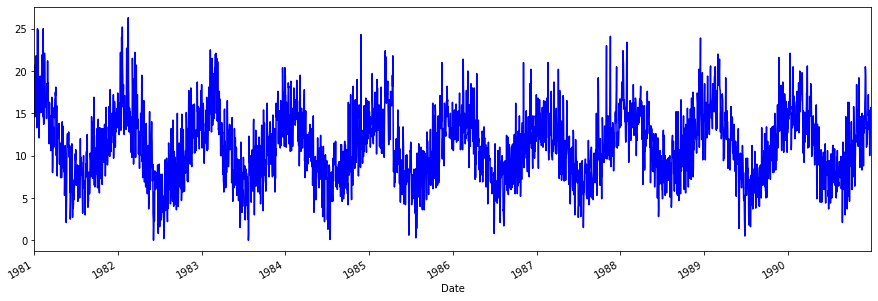

In [4]:
df.Temp.plot(figsize=(15, 5), color ="b")

# Dataset Splitting

In [5]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [6]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [7]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [8]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.gru(x, hidden)
        x = self.fc(x)
        return x, hidden

In [9]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 3,
    "dropout": 0
})

# Training Preparation -> MCOC

In [10]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/gru")

# Training

In [11]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset,dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode =="test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 129.5904 | Test_cost  = 121.5531 | 




Epoch     2
Train_cost  = 101.8768 | Test_cost  = 90.4523 | 




Epoch     3
Train_cost  = 75.0290 | Test_cost  = 69.3780 | 




Epoch     4
Train_cost  = 58.7868 | Test_cost  = 57.2145 | 




Epoch     5
Train_cost  = 49.0556 | Test_cost  = 49.0186 | 




Epoch     6
Train_cost  = 42.2000 | Test_cost  = 42.7921 | 




Epoch     7
Train_cost  = 36.8921 | Test_cost  = 37.7797 | 




Epoch     8
Train_cost  = 32.6093 | Test_cost  = 33.6665 | 




Epoch     9
Train_cost  = 29.1235 | Test_cost  = 30.2914 | 




Epoch    10
Train_cost  = 26.2995 | Test_cost  = 27.5377 | 




Epoch    11
Train_cost  = 24.0302 | Test_cost  = 25.3058 | 




Epoch    12
Train_cost  = 22.2228 | Test_cost  = 23.5089 | 




Epoch    13
Train_cost  = 20.7962 | Test_cost  = 22.0714 | 




Epoch    14
Train_cost  = 19.6804 | Test_cost  = 20.9286 | 




Epoch    15
Train_cost  = 18.8159 | Test_cost  = 20.0258 | 




Epoch    16
Train_cost  = 18.1526 | Test_cost  = 19.3167 | 




Epoch    17
Train_cost  = 17.6489 | Test_cost  = 18.7629 | 




Epoch    18
Train_cost  = 17.2702 | Test_cost  = 18.3325 | 




Epoch    19
Train_cost  = 16.9883 | Test_cost  = 17.9994 | 




Epoch    20
Train_cost  = 16.7806 | Test_cost  = 17.7425 | 


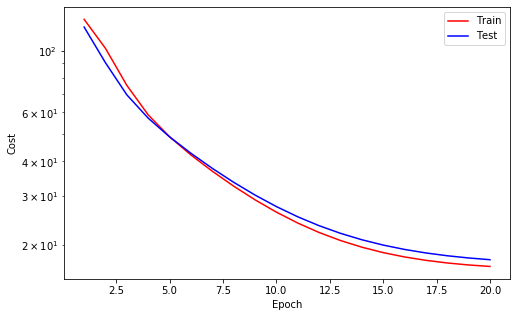



Epoch    21
Train_cost  = 16.6289 | Test_cost  = 17.5448 | 




Epoch    22
Train_cost  = 16.5191 | Test_cost  = 17.3929 | 




Epoch    23
Train_cost  = 16.4401 | Test_cost  = 17.2761 | 




Epoch    24
Train_cost  = 16.3835 | Test_cost  = 17.1862 | 




Epoch    25
Train_cost  = 16.3431 | Test_cost  = 17.1170 | 




Epoch    26
Train_cost  = 16.3141 | Test_cost  = 17.0635 | 




Epoch    27
Train_cost  = 16.2932 | Test_cost  = 17.0219 | 




Epoch    28
Train_cost  = 16.2778 | Test_cost  = 16.9896 | 




Epoch    29
Train_cost  = 16.2664 | Test_cost  = 16.9643 | 




Epoch    30
Train_cost  = 16.2576 | Test_cost  = 16.9444 | 




Epoch    31
Train_cost  = 16.2506 | Test_cost  = 16.9287 | 




Epoch    32
Train_cost  = 16.2448 | Test_cost  = 16.9162 | 




Epoch    33
Train_cost  = 16.2398 | Test_cost  = 16.9062 | 




Epoch    34
Train_cost  = 16.2354 | Test_cost  = 16.8980 | 




Epoch    35
Train_cost  = 16.2314 | Test_cost  = 16.8914 | 




Epoch    36
Train_cost  = 16.2275 | Test_cost  = 16.8859 | 




Epoch    37
Train_cost  = 16.2239 | Test_cost  = 16.8812 | 




Epoch    38
Train_cost  = 16.2203 | Test_cost  = 16.8772 | 




Epoch    39
Train_cost  = 16.2167 | Test_cost  = 16.8737 | 




Epoch    40
Train_cost  = 16.2132 | Test_cost  = 16.8706 | 


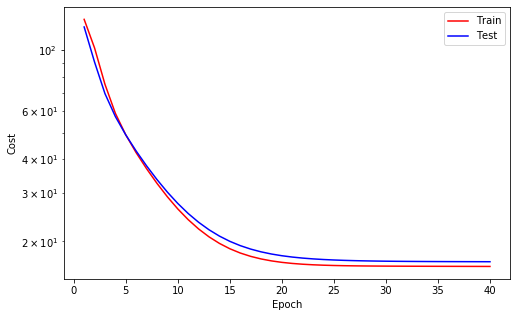



Epoch    41
Train_cost  = 16.2097 | Test_cost  = 16.8677 | 




Epoch    42
Train_cost  = 16.2061 | Test_cost  = 16.8651 | 




Epoch    43
Train_cost  = 16.2025 | Test_cost  = 16.8625 | 




Epoch    44
Train_cost  = 16.1988 | Test_cost  = 16.8601 | 




Epoch    45
Train_cost  = 16.1951 | Test_cost  = 16.8577 | 




Epoch    46
Train_cost  = 16.1913 | Test_cost  = 16.8554 | 




Epoch    47
Train_cost  = 16.1874 | Test_cost  = 16.8531 | 




Epoch    48
Train_cost  = 16.1834 | Test_cost  = 16.8508 | 




Epoch    49
Train_cost  = 16.1794 | Test_cost  = 16.8485 | 




Epoch    50
Train_cost  = 16.1752 | Test_cost  = 16.8463 | 




Epoch    51
Train_cost  = 16.1709 | Test_cost  = 16.8440 | 




Epoch    52
Train_cost  = 16.1664 | Test_cost  = 16.8417 | 




Epoch    53
Train_cost  = 16.1618 | Test_cost  = 16.8393 | 




Epoch    54
Train_cost  = 16.1571 | Test_cost  = 16.8370 | 




Epoch    55
Train_cost  = 16.1521 | Test_cost  = 16.8346 | 




Epoch    56
Train_cost  = 16.1470 | Test_cost  = 16.8322 | 




Epoch    57
Train_cost  = 16.1415 | Test_cost  = 16.8298 | 




Epoch    58
Train_cost  = 16.1358 | Test_cost  = 16.8273 | 




Epoch    59
Train_cost  = 16.1298 | Test_cost  = 16.8246 | 




Epoch    60
Train_cost  = 16.1233 | Test_cost  = 16.8219 | 


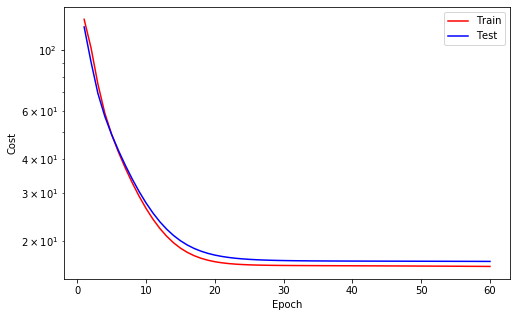



Epoch    61
Train_cost  = 16.1163 | Test_cost  = 16.8191 | 




Epoch    62
Train_cost  = 16.1085 | Test_cost  = 16.8160 | 




Epoch    63
Train_cost  = 16.0999 | Test_cost  = 16.8125 | 




Epoch    64
Train_cost  = 16.0898 | Test_cost  = 16.8084 | 




Epoch    65
Train_cost  = 16.0777 | Test_cost  = 16.8034 | 




Epoch    66
Train_cost  = 16.0623 | Test_cost  = 16.7967 | 




Epoch    67
Train_cost  = 16.0410 | Test_cost  = 16.7864 | 




Epoch    68
Train_cost  = 16.0079 | Test_cost  = 16.7658 | 




Epoch    69
Train_cost  = 15.9433 | Test_cost  = 16.6949 | 




Epoch    70
Train_cost  = 15.7097 | Test_cost  = 15.9092 | 




Epoch    71
Train_cost  = 14.1387 | Test_cost  = 14.3127 | 




Epoch    72
Train_cost  = 13.1877 | Test_cost  = 13.2409 | 




Epoch    73
Train_cost  = 12.1530 | Test_cost  = 12.3738 | 




Epoch    74
Train_cost  = 11.4297 | Test_cost  = 11.3522 | 




Epoch    75
Train_cost  = 10.7056 | Test_cost  = 10.5708 | 




Epoch    76
Train_cost  = 10.1242 | Test_cost  = 9.9147 | 




Epoch    77
Train_cost  = 9.6921 | Test_cost  = 9.3067 | 




Epoch    78
Train_cost  = 9.2876 | Test_cost  = 8.8310 | 




Epoch    79
Train_cost  = 8.9246 | Test_cost  = 8.4449 | 




Epoch    80
Train_cost  = 8.6317 | Test_cost  = 8.1245 | 


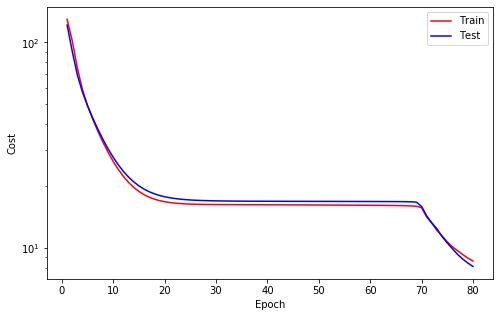



Epoch    81
Train_cost  = 8.4005 | Test_cost  = 7.8549 | 




Epoch    82
Train_cost  = 8.2083 | Test_cost  = 7.6196 | 




Epoch    83
Train_cost  = 8.0327 | Test_cost  = 7.4134 | 




Epoch    84
Train_cost  = 7.8674 | Test_cost  = 7.2354 | 




Epoch    85
Train_cost  = 7.7202 | Test_cost  = 7.0801 | 




Epoch    86
Train_cost  = 7.5952 | Test_cost  = 6.9427 | 




Epoch    87
Train_cost  = 7.4897 | Test_cost  = 6.8219 | 




Epoch    88
Train_cost  = 7.3994 | Test_cost  = 6.7150 | 




Epoch    89
Train_cost  = 7.3198 | Test_cost  = 6.6187 | 




Epoch    90
Train_cost  = 7.2479 | Test_cost  = 6.5315 | 




Epoch    91
Train_cost  = 7.1824 | Test_cost  = 6.4521 | 




Epoch    92
Train_cost  = 7.1226 | Test_cost  = 6.3796 | 




Epoch    93
Train_cost  = 7.0678 | Test_cost  = 6.3130 | 




Epoch    94
Train_cost  = 7.0176 | Test_cost  = 6.2515 | 




Epoch    95
Train_cost  = 6.9713 | Test_cost  = 6.1944 | 




Epoch    96
Train_cost  = 6.9285 | Test_cost  = 6.1413 | 




Epoch    97
Train_cost  = 6.8886 | Test_cost  = 6.0918 | 




Epoch    98
Train_cost  = 6.8513 | Test_cost  = 6.0454 | 




Epoch    99
Train_cost  = 6.8164 | Test_cost  = 6.0019 | 




Epoch   100
Train_cost  = 6.7834 | Test_cost  = 5.9610 | 


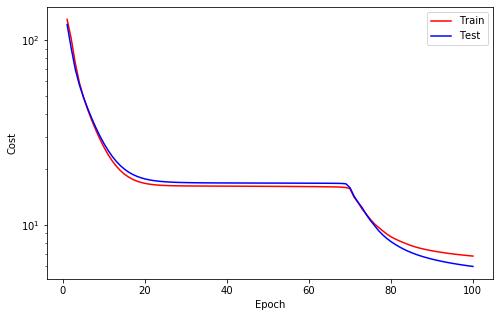



Epoch   101
Train_cost  = 6.7523 | Test_cost  = 5.9226 | 




Epoch   102
Train_cost  = 6.7229 | Test_cost  = 5.8864 | 




Epoch   103
Train_cost  = 6.6950 | Test_cost  = 5.8522 | 




Epoch   104
Train_cost  = 6.6685 | Test_cost  = 5.8199 | 




Epoch   105
Train_cost  = 6.6433 | Test_cost  = 5.7892 | 




Epoch   106
Train_cost  = 6.6194 | Test_cost  = 5.7599 | 




Epoch   107
Train_cost  = 6.5965 | Test_cost  = 5.7320 | 




Epoch   108
Train_cost  = 6.5748 | Test_cost  = 5.7054 | 




Epoch   109
Train_cost  = 6.5541 | Test_cost  = 5.6798 | 




Epoch   110
Train_cost  = 6.5344 | Test_cost  = 5.6553 | 




Epoch   111
Train_cost  = 6.5157 | Test_cost  = 5.6317 | 




Epoch   112
Train_cost  = 6.4980 | Test_cost  = 5.6091 | 




Epoch   113
Train_cost  = 6.4812 | Test_cost  = 5.5873 | 




Epoch   114
Train_cost  = 6.4651 | Test_cost  = 5.5664 | 




Epoch   115
Train_cost  = 6.4499 | Test_cost  = 5.5463 | 




Epoch   116
Train_cost  = 6.4353 | Test_cost  = 5.5269 | 




Epoch   117
Train_cost  = 6.4215 | Test_cost  = 5.5083 | 




Epoch   118
Train_cost  = 6.4082 | Test_cost  = 5.4904 | 




Epoch   119
Train_cost  = 6.3955 | Test_cost  = 5.4731 | 




Epoch   120
Train_cost  = 6.3834 | Test_cost  = 5.4565 | 


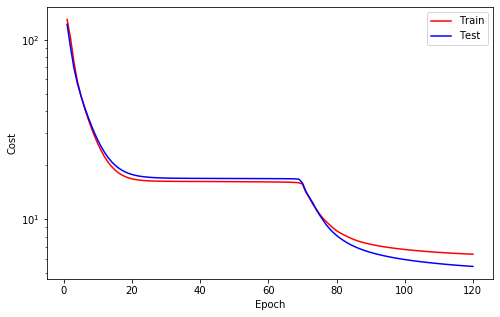



Epoch   121
Train_cost  = 6.3717 | Test_cost  = 5.4406 | 




Epoch   122
Train_cost  = 6.3605 | Test_cost  = 5.4253 | 




Epoch   123
Train_cost  = 6.3497 | Test_cost  = 5.4106 | 




Epoch   124
Train_cost  = 6.3393 | Test_cost  = 5.3965 | 




Epoch   125
Train_cost  = 6.3293 | Test_cost  = 5.3829 | 




Epoch   126
Train_cost  = 6.3197 | Test_cost  = 5.3699 | 




Epoch   127
Train_cost  = 6.3104 | Test_cost  = 5.3575 | 




Epoch   128
Train_cost  = 6.3014 | Test_cost  = 5.3455 | 




Epoch   129
Train_cost  = 6.2928 | Test_cost  = 5.3341 | 




Epoch   130
Train_cost  = 6.2844 | Test_cost  = 5.3231 | 




Epoch   131
Train_cost  = 6.2763 | Test_cost  = 5.3125 | 




Epoch   132
Train_cost  = 6.2685 | Test_cost  = 5.3024 | 




Epoch   133
Train_cost  = 6.2609 | Test_cost  = 5.2926 | 




Epoch   134
Train_cost  = 6.2536 | Test_cost  = 5.2832 | 




Epoch   135
Train_cost  = 6.2465 | Test_cost  = 5.2741 | 




Epoch   136
Train_cost  = 6.2395 | Test_cost  = 5.2654 | 




Epoch   137
Train_cost  = 6.2328 | Test_cost  = 5.2570 | 




Epoch   138
Train_cost  = 6.2263 | Test_cost  = 5.2488 | 




Epoch   139
Train_cost  = 6.2200 | Test_cost  = 5.2410 | 




Epoch   140
Train_cost  = 6.2139 | Test_cost  = 5.2334 | 


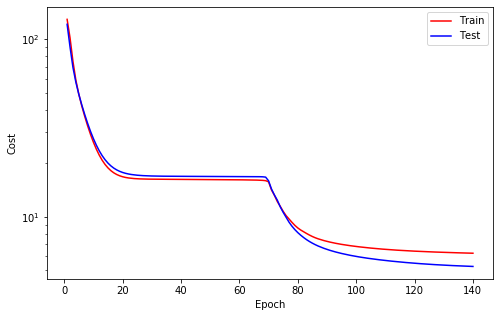



Epoch   141
Train_cost  = 6.2080 | Test_cost  = 5.2260 | 




Epoch   142
Train_cost  = 6.2022 | Test_cost  = 5.2189 | 




Epoch   143
Train_cost  = 6.1967 | Test_cost  = 5.2120 | 




Epoch   144
Train_cost  = 6.1913 | Test_cost  = 5.2054 | 




Epoch   145
Train_cost  = 6.1861 | Test_cost  = 5.1989 | 




Epoch   146
Train_cost  = 6.1811 | Test_cost  = 5.1927 | 




Epoch   147
Train_cost  = 6.1760 | Test_cost  = 5.1867 | 




Epoch   148
Train_cost  = 6.1710 | Test_cost  = 5.1810 | 




Epoch   149
Train_cost  = 6.1659 | Test_cost  = 5.1755 | 




Epoch   150
Train_cost  = 6.1608 | Test_cost  = 5.1703 | 




Epoch   151
Train_cost  = 6.1555 | Test_cost  = 5.1653 | 




Epoch   152
Train_cost  = 6.1502 | Test_cost  = 5.1606 | 




Epoch   153
Train_cost  = 6.1449 | Test_cost  = 5.1561 | 




Epoch   154
Train_cost  = 6.1396 | Test_cost  = 5.1518 | 




Epoch   155
Train_cost  = 6.1345 | Test_cost  = 5.1477 | 




Epoch   156
Train_cost  = 6.1294 | Test_cost  = 5.1438 | 




Epoch   157
Train_cost  = 6.1245 | Test_cost  = 5.1400 | 




Epoch   158
Train_cost  = 6.1196 | Test_cost  = 5.1363 | 




Epoch   159
Train_cost  = 6.1149 | Test_cost  = 5.1328 | 




Epoch   160
Train_cost  = 6.1103 | Test_cost  = 5.1295 | 


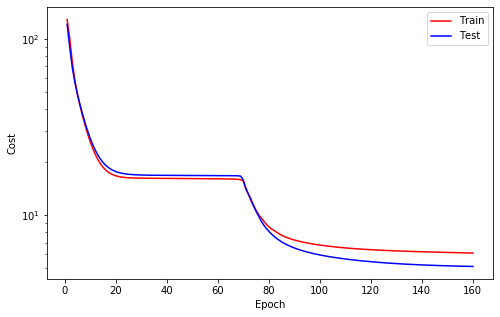



Epoch   161
Train_cost  = 6.1057 | Test_cost  = 5.1264 | 




Epoch   162
Train_cost  = 6.1011 | Test_cost  = 5.1234 | 




Epoch   163
Train_cost  = 6.0966 | Test_cost  = 5.1206 | 




Epoch   164
Train_cost  = 6.0921 | Test_cost  = 5.1179 | 




Epoch   165
Train_cost  = 6.0877 | Test_cost  = 5.1154 | 




Epoch   166
Train_cost  = 6.0832 | Test_cost  = 5.1130 | 




Epoch   167
Train_cost  = 6.0788 | Test_cost  = 5.1107 | 




Epoch   168
Train_cost  = 6.0745 | Test_cost  = 5.1086 | 




Epoch   169
Train_cost  = 6.0702 | Test_cost  = 5.1066 | 




Epoch   170
Train_cost  = 6.0659 | Test_cost  = 5.1048 | 




Epoch   171
Train_cost  = 6.0616 | Test_cost  = 5.1030 | 




Epoch   172
Train_cost  = 6.0574 | Test_cost  = 5.1014 | 




Epoch   173
Train_cost  = 6.0533 | Test_cost  = 5.0999 | 




Epoch   174
Train_cost  = 6.0492 | Test_cost  = 5.0985 | 




Epoch   175
Train_cost  = 6.0451 | Test_cost  = 5.0972 | 




Epoch   176
Train_cost  = 6.0411 | Test_cost  = 5.0961 | 




Epoch   177
Train_cost  = 6.0372 | Test_cost  = 5.0950 | 




Epoch   178
Train_cost  = 6.0332 | Test_cost  = 5.0941 | 




Epoch   179
Train_cost  = 6.0293 | Test_cost  = 5.0932 | 




Epoch   180
Train_cost  = 6.0254 | Test_cost  = 5.0924 | 


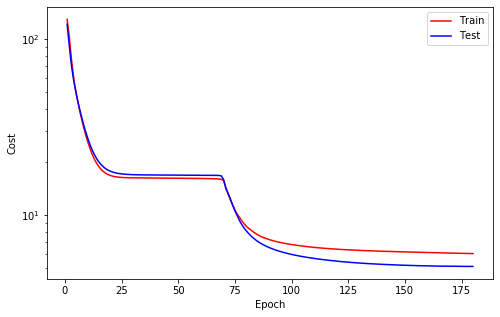



Epoch   181
Train_cost  = 6.0216 | Test_cost  = 5.0917 | 




Epoch   182
Train_cost  = 6.0178 | Test_cost  = 5.0911 | 




Epoch   183
Train_cost  = 6.0140 | Test_cost  = 5.0905 | 




Epoch   184
Train_cost  = 6.0102 | Test_cost  = 5.0900 | 




Epoch   185
Train_cost  = 6.0064 | Test_cost  = 5.0896 | 




Epoch   186
Train_cost  = 6.0026 | Test_cost  = 5.0892 | 




Epoch   187
Train_cost  = 5.9988 | Test_cost  = 5.0888 | 




Epoch   188
Train_cost  = 5.9950 | Test_cost  = 5.0885 | 




Epoch   189
Train_cost  = 5.9912 | Test_cost  = 5.0882 | 




Epoch   190
Train_cost  = 5.9874 | Test_cost  = 5.0880 | 




Epoch   191
Train_cost  = 5.9835 | Test_cost  = 5.0878 | 




Epoch   192
Train_cost  = 5.9797 | Test_cost  = 5.0876 | 




Epoch   193
Train_cost  = 5.9758 | Test_cost  = 5.0874 | 




Epoch   194
Train_cost  = 5.9719 | Test_cost  = 5.0873 | 




Epoch   195
Train_cost  = 5.9679 | Test_cost  = 5.0872 | 




Epoch   196
Train_cost  = 5.9640 | Test_cost  = 5.0871 | 




Epoch   197
Train_cost  = 5.9599 | Test_cost  = 5.0871 | 




Epoch   198
Train_cost  = 5.9559 | Test_cost  = 5.0871 | 




Epoch   199
Train_cost  = 5.9517 | Test_cost  = 5.0871 | 
==> EarlyStop patience =  1 | Best test_cost: 5.0871




Epoch   200
Train_cost  = 5.9476 | Test_cost  = 5.0872 | 


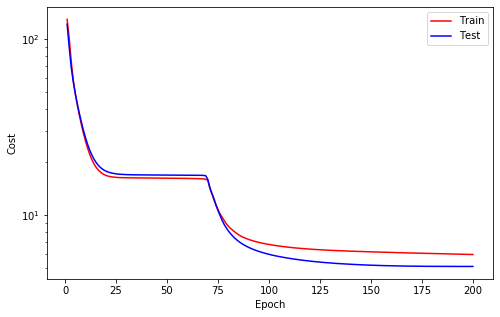

==> EarlyStop patience =  2 | Best test_cost: 5.0871




Epoch   201
Train_cost  = 5.9434 | Test_cost  = 5.0873 | 
==> EarlyStop patience =  3 | Best test_cost: 5.0871




Epoch   202
Train_cost  = 5.9391 | Test_cost  = 5.0874 | 
==> EarlyStop patience =  4 | Best test_cost: 5.0871




Epoch   203
Train_cost  = 5.9347 | Test_cost  = 5.0876 | 
==> EarlyStop patience =  5 | Best test_cost: 5.0871
==> Execute Early Stopping at epoch: 203 | Best test_cost: 5.0871
==> Best model is saved at model/gru


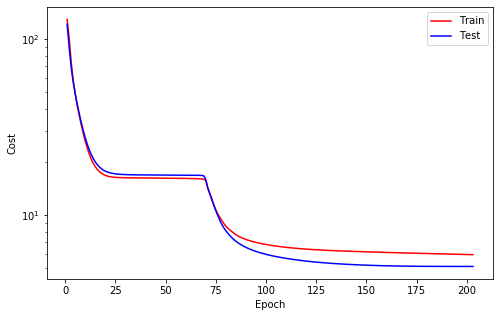

In [12]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost)
    
    #Checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    
    #Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [13]:
from luwiji.rnn import illustration

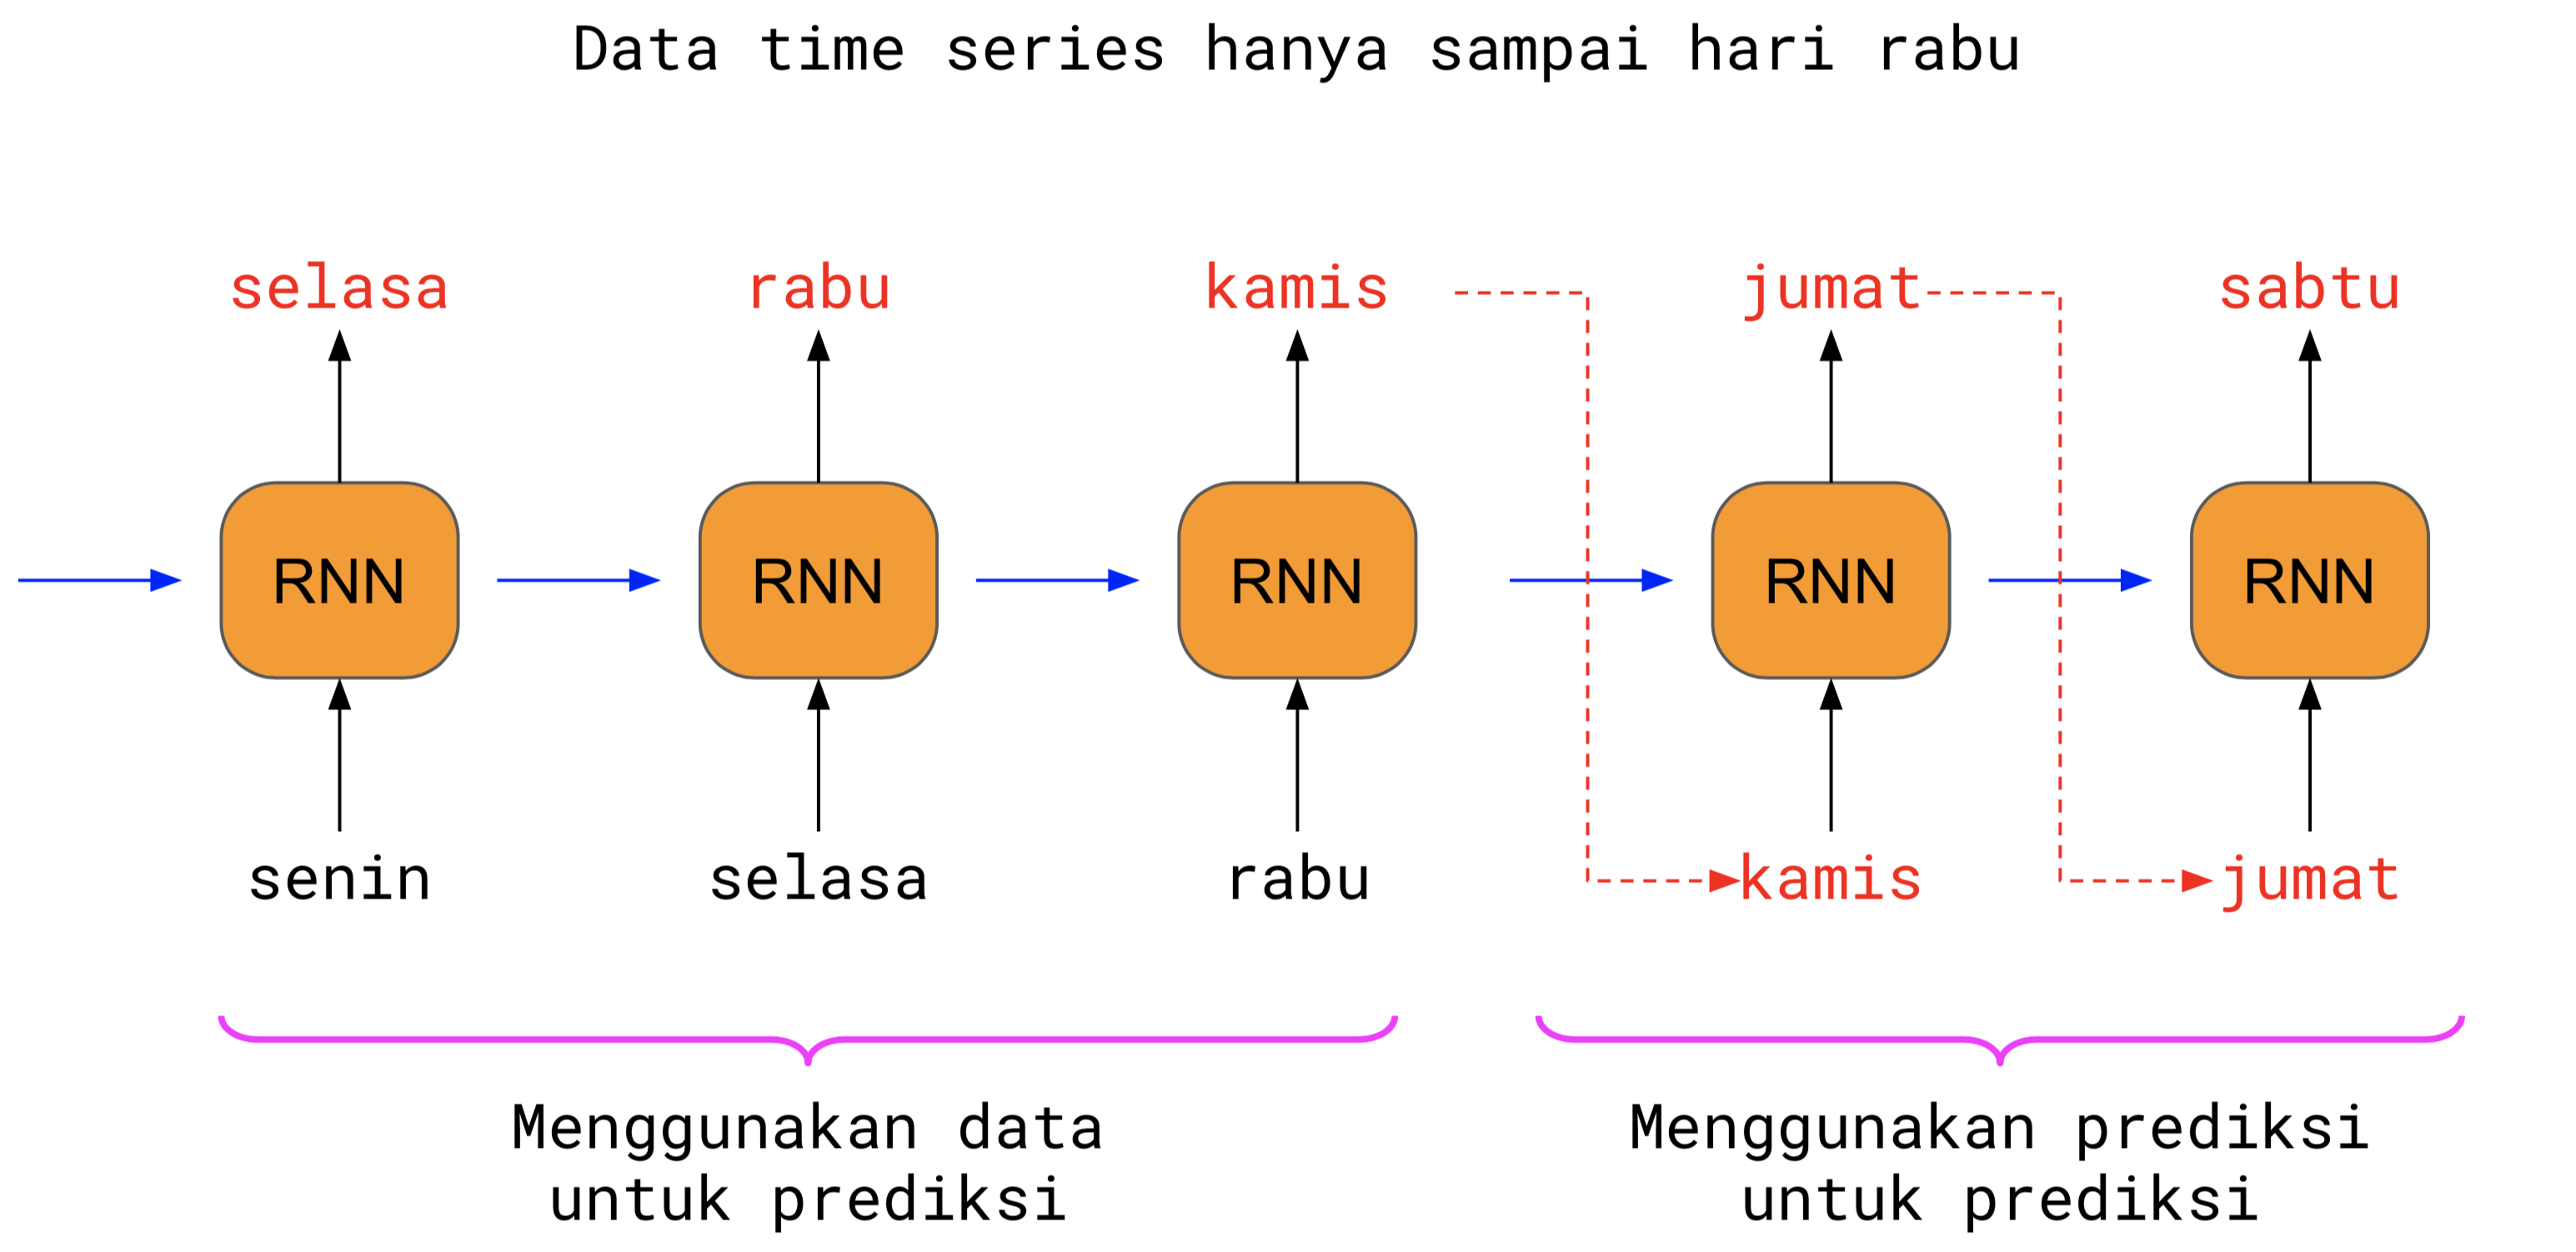

In [14]:
illustration.forecast

In [15]:
from utils import data4pred, pred4pred

In [16]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

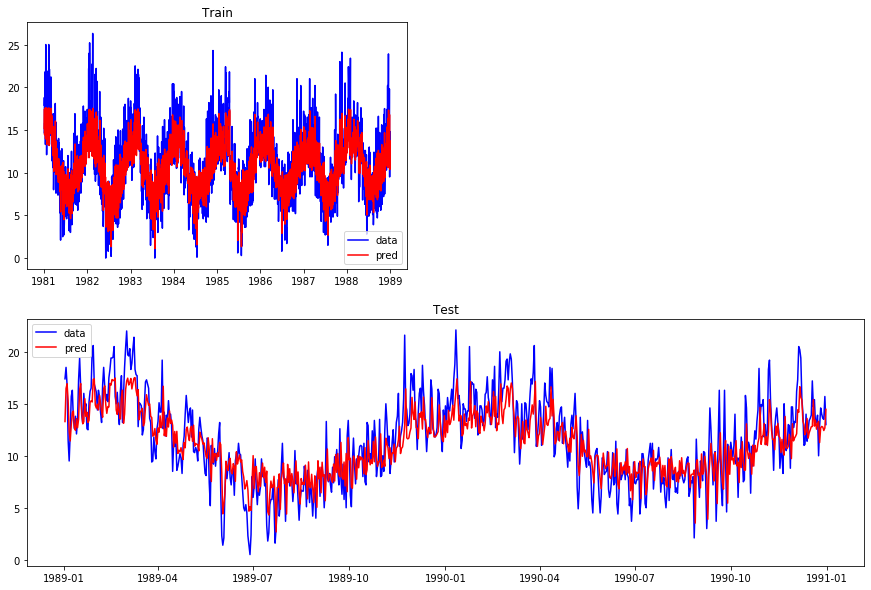

In [17]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(221)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

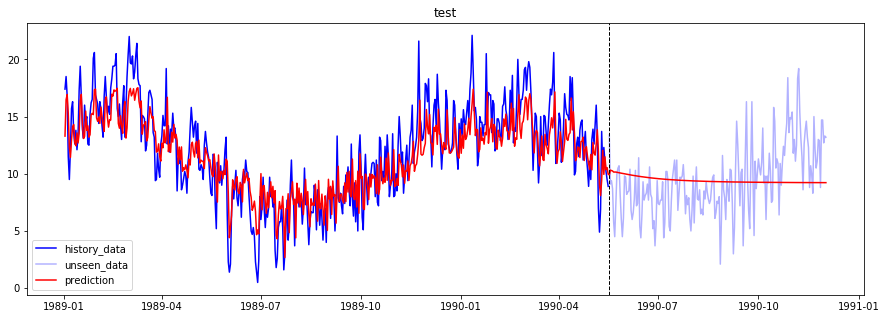

In [18]:
# Pred 4 Pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")